In [6]:
import torch
from torch import nn, optim
import numpy as np
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.datasets import make_swiss_roll
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pickle as pkl
import random
from sklearn.model_selection import train_test_split
import glob
import MDAnalysis as mda
import itertools

import skorch


In [3]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using {device} device.")

Using cuda device.


In [4]:
torch.cuda.empty_cache()

In [5]:
# The encoder


class Autoencoder(nn.Module):

    def __init__(self, in_shape, enc_shape, middle_shape):
        super(Autoencoder, self).__init__()

        self.encode = nn.Sequential(
            nn.Linear(in_shape, middle_shape),
            nn.ReLU(True),
            nn.Linear(middle_shape, middle_shape),
            nn.ReLU(True),
            nn.Linear(middle_shape, middle_shape),
            nn.ReLU(True),
            nn.Linear(middle_shape, enc_shape)
        )

        self.decode = nn.Sequential(
            nn.Linear(enc_shape, middle_shape),
            nn.ReLU(True),
            nn.Linear(middle_shape, middle_shape),
            nn.ReLU(True),
            nn.Linear(middle_shape, middle_shape),
            nn.ReLU(True),
            nn.Linear(middle_shape, in_shape)
        )
        
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

In [9]:
def create_ae(in_shape, enc_shape, middle_shape):
    return Autoencoder(in_shape=in_shape, enc_shape=enc_shape, middle_shape=middle_shape)


In [11]:
m = skorch.NeuralNet(
    Autoencoder(10, 2, 30),
    criterion=nn.MSELoss,
    optimizer=torch.optim.Adam
)

In [13]:
print(m)

<class 'skorch.net.NeuralNet'>[uninitialized](
  module=Autoencoder(
    (encode): Sequential(
      (0): Linear(in_features=10, out_features=30, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=30, out_features=30, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=30, out_features=30, bias=True)
      (5): ReLU(inplace=True)
      (6): Linear(in_features=30, out_features=2, bias=True)
    )
    (decode): Sequential(
      (0): Linear(in_features=2, out_features=30, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=30, out_features=30, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=30, out_features=30, bias=True)
      (5): ReLU(inplace=True)
      (6): Linear(in_features=30, out_features=10, bias=True)
    )
  ),
)


In [130]:
# Function to train encoder

def train(model, error, optimizer, n_epochs, batch_size, x, plot):
    
    model.train()
    indices = [i for i in range(x.shape[0])]
    errors = []
    
    for epoch in range(n_epochs):
        
        random.shuffle(indices)
        batches = [i for i in range(0, len(indices), batch_size)]

        for i in range(len(batches) - 1):
            
            batch_x = x[indices[batches[i]:batches[i+1]]]
            optimizer.zero_grad()
            output = model(batch_x)
            loss = error(output, batch_x)
            loss.backward()
            optimizer.step()
            errors.append(loss.cpu().detach().numpy())
            
        if epoch % int(0.1*n_epochs) == 0:
            print(f'epoch {epoch} \t Loss: {loss.item():.4g}')
    
    if plot:
        plt.plot(errors)

In [131]:
with open('data_dict.pkl', 'rb') as f:
    loaded_dict = pkl.load(f)

In [132]:
systems = ["sdpc", "chol-site-3"]

X = np.concatenate([v for k, v in loaded_dict.items() if k in systems])

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

X = X[0:-1:2,:]
X = torch.Tensor(X).double().to(device)

In [133]:
ids = []

for id, (k, v) in enumerate(loaded_dict.items()):
    if k in systems:
        for i in range(v.shape[0]):
            ids.append(id)
ids = np.array(ids)
ids = ids[0:-1:2]

In [134]:
# function to split data into train and test sets
def train_test_split(X, test_size):
    
    indices = [i for i in range(X.shape[0])]
    random.shuffle(indices)
    
    test_indices = indices[:int(test_size*len(indices))]
    train_indices = indices[int(test_size*len(indices)):]

    trainX = X[train_indices,:]
    testX = X[test_indices,:]
    
    return trainX, testX, train_indices, test_indices
    
    

In [135]:
trainX, testX, train_indices, test_indices = train_test_split(X, 0.8)

In [136]:
# Define dimensions
enc_shape = 2
inc_shape = X.shape[1]
middle_shape = 4

In [137]:
# Define model and params
encoder = Autoencoder(in_shape=inc_shape, enc_shape=enc_shape, middle_shape=middle_shape).double().to(device)
error = nn.MSELoss()
optimizer = optim.Adam(encoder.parameters(), lr=1e-3)

In [138]:
# Train encoder
train(encoder, error, optimizer, 50, 128, trainX, plot=False)

epoch 5 	 Loss: 1.076
epoch 10 	 Loss: 1.049
epoch 15 	 Loss: 1.065
epoch 20 	 Loss: 1.05
epoch 25 	 Loss: 1.029
epoch 30 	 Loss: 0.9772
epoch 35 	 Loss: 0.9452
epoch 40 	 Loss: 0.9179
epoch 45 	 Loss: 0.919
epoch 50 	 Loss: 0.9012


In [139]:
with torch.no_grad():
    encoded = encoder.encode(testX)
    decoded = encoder.decode(encoded)
    err = error(decoded, testX).item()
    print(f"Error on test set: {err}")
    E = decoded - testX
    enc = encoded.cpu().detach().numpy()
    dec = decoded.cpu().detach().numpy()

Error on test set: 0.894926997105747


(array([1979.,    0.,    0.,    0.,    0.,    0.,    0., 2024.]),
 array([5.   , 5.125, 5.25 , 5.375, 5.5  , 5.625, 5.75 , 5.875, 6.   ]),
 <BarContainer object of 8 artists>)

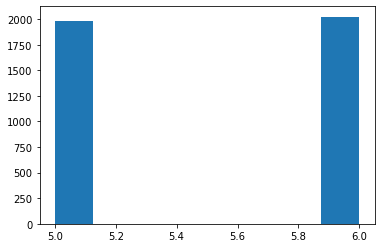

In [140]:
systems = ids[test_indices]
plt.hist(systems, bins=8)

In [141]:
scaled_back_X = scaler.inverse_transform(testX.cpu())
scaled_back_dec = scaler.inverse_transform(dec)
scaled_back_error = np.mean((scaled_back_dec - scaled_back_X)**2)
print(scaled_back_error)

9.409833907938443


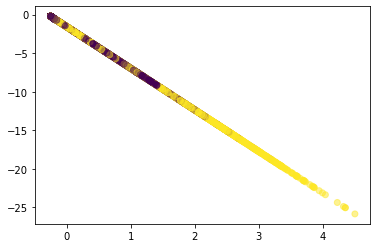

In [142]:

plt.scatter(enc[:,0], enc[:,1], c=ids[test_indices], alpha=0.5)


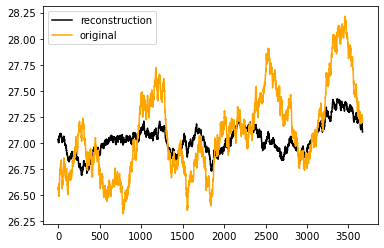

In [143]:
# Plotting running means of atom positions for reconstruction and original
n = 0
conv = 333
w = np.convolve(scaled_back_dec[:,n], np.ones(conv)/conv, mode='valid')
q = np.convolve(scaled_back_X[:,n], np.ones(conv)/conv, mode='valid')

plt.plot(w, color='k', label="reconstruction")
plt.plot(q, color='orange', label="original")
plt.legend()

In [144]:

def write_reconstruction(reconst_arr, universe, filename):
    
    atoms = universe.select_atoms("name CA")
    atoms.write(f"{filename}.gro")
    with mda.Writer(f"{filename}.xtc", atoms.n_atoms) as W:
        for ts in range(reconst_arr.shape[0]):
            pos = reconst_arr[ts,:].reshape(311,3)
            atoms.positions = pos
            W.write(atoms)
    
    
    

"""write_reconstruction(dec,
                     mda.Universe("/wrk/eurastof/binding_spots_project/gpcr_sampling/b2ar/b2ar_centered_aligned/chol-sdpc-site-2/step6.6_equilibration.gro"),
                     "./reconst")"""





'write_reconstruction(dec,\n                     mda.Universe("/wrk/eurastof/binding_spots_project/gpcr_sampling/b2ar/b2ar_centered_aligned/chol-sdpc-site-2/step6.6_equilibration.gro"),\n                     "./reconst")'